In [1]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.util.pareto import ParetoFront
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.HvEI import AcquisitionHvEI
from GPyOpt.methods import ModularBayesianMultiobjectiveOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
def Kursawe(x):
    f1 = -10*np.exp(-0.2*np.sqrt(x[0]**2+x[1]**2))-10*np.exp(-0.2*np.sqrt(x[1]**2+x[2]**2))
    f2 = np.sum(np.absolute(x)**0.8+5.0*np.sin(x**3))
    return np.array([f1,f2])

In [5]:
np.set_printoptions(precision=6)

objective = None 

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-5.0,5.0)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-5.0,5.0)},
        {'name': 'var_3', 'type': 'continuous', 'domain': (-5.0,5.0)}]
space = GPyOpt.Design_space(space = space)

kernel   = None 
kernel_c = None

model_f1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f  = [model_f1,model_f2]

model_c  = []

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

num_init = 33
typ_init = 'latin'
X_init = initial_design(typ_init,space,num_init)

Y_init = np.zeros((X_init.shape[0],2))

for i in range(num_init):
    Y_init[i,:] = Kursawe(X_init[i,:])

np.set_printoptions(precision=4)
print(np.hstack((X_init,Y_init)))

[[  3.6364  -1.2121   3.9394  -9.0311  -6.977 ]
 [ -0.6061   2.4242  -0.9091 -12.0249   4.0802]
 [ -2.7273   0.303   -3.3333 -10.8964   3.4945]
 [ -3.0303   4.2424   2.7273  -7.172   14.7152]
 [  0.6061  -0.9091   3.0303 -13.3484   3.8802]
 [  3.9394   1.2121   4.8485  -8.0658  11.48  ]
 [  1.2121   3.3333  -3.6364  -8.648   12.5082]
 [  4.2424   4.8485  -1.8182  -6.3068  17.6156]
 [ -3.3333   0.6061   1.2121 -12.7042  13.524 ]
 [  1.5152  -4.2424   3.3333  -7.4609  -1.623 ]
 [  0.       3.0303   4.5455  -8.8084   6.3143]
 [ -2.1212   1.8182   2.1212 -11.4384   3.9168]
 [  4.5455  -3.0303  -4.2424  -6.8785   1.0723]
 [ -1.8182   2.7273  -3.0303  -9.6163  10.4083]
 [  2.4242   3.9394   0.      -8.513    5.035 ]
 [  0.303    1.5152   0.9091 -14.3646   4.6058]
 [  3.3333  -2.7273   2.4242  -9.0459   3.8236]
 [ -0.303   -1.5152  -1.2121 -14.1252  -0.4318]
 [  2.1212  -4.8485  -4.8485  -6.0076   0.5927]
 [ -4.5455  -3.9394  -0.6061  -7.5091  12.5151]
 [  2.7273  -1.8182  -3.9394  -9.3905  1

In [6]:
iter_count = 150-num_init
current_iter = 0
X_step = X_init
Y_step = Y_init

while current_iter < iter_count:
    Pareto = ParetoFront(Y_step)
    
    print(Pareto.shape)
    
    acquisition = AcquisitionHvEI(model_f,space,optimizer=aquisition_optimizer, jitter = 1e-3,
                                  model_c=model_c,P=Pareto,r=np.array([-14,2]))
    
    # --- CHOOSE a collection method
    evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
    
    bo_step = ModularBayesianMultiobjectiveOptimization(model_f, space, objective, acquisition, evaluator, 
                                                        X_init = X_step, Y_init = Y_step, model_c = model_c, 
                                                        normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = Kursawe(x_next[0])
    print("Current iteration - ",current_iter," : ",np.hstack((x_next[0],y_next)))
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    
    current_iter += 1

(4, 2)
Current iteration -  0  :  [ -0.785   -0.1183   0.0331 -18.2892  -1.263 ]
(3, 2)
Current iteration -  1  :  [ -0.575   -0.0747   0.085  -18.6812  -0.0369]
(4, 2)
Current iteration -  2  :  [ -0.4923  -0.0653   0.1234 -18.7791   0.2804]
(5, 2)
Current iteration -  3  :  [ -0.4908  -0.046    0.1574 -18.7384   0.3081]
(5, 2)
Current iteration -  4  :  [-3.6861e-02 -4.2088e-02  1.1066e-02 -1.9802e+01  1.7726e-01]
(5, 2)
Current iteration -  5  :  [  0.7138   0.0911  -0.4746 -17.7384   2.7105]
(5, 2)
Current iteration -  6  :  [ -0.0981  -0.0263   0.1108 -19.5737   0.3846]
(5, 2)
Current iteration -  7  :  [ -0.0357  -0.0559   0.1255 -19.5971   0.368 ]
(5, 2)
Current iteration -  8  :  [-9.5943e-03 -8.3318e-02  1.7448e-01 -1.9454e+01  4.3232e-01]
(5, 2)
Current iteration -  9  :  [  0.0532  -0.1246   0.2235 -19.2336   0.6332]
(5, 2)
Current iteration -  10  :  [  0.0304  -0.1077   0.2075 -19.3218   0.5521]
(5, 2)
Current iteration -  11  :  [  0.0323  -0.1051   0.1979 -19.344    0.53

Current iteration -  98  :  [-1.1121e+00  4.8725e-03 -2.1988e-01 -1.7575e+01 -3.5576e+00]
(15, 2)
Current iteration -  99  :  [ 7.3906e-02 -6.1366e-02 -5.5399e-01 -1.8755e+01  9.9548e-03]
(16, 2)
Current iteration -  100  :  [ -1.2487  -1.4639  -4.8312 -10.4492   3.0582]
(16, 2)
Current iteration -  101  :  [ -0.9165  -0.1191  -1.0355 -16.4306  -5.8249]
(16, 2)
Current iteration -  102  :  [ -1.008   -0.9573  -0.9134 -15.2478  -8.6657]
(17, 2)
Current iteration -  103  :  [-7.1009e-01  4.3515e-02  7.3246e-03 -1.8586e+01 -8.9035e-01]
(18, 2)
Current iteration -  104  :  [ -0.2407   0.0928  -0.4382 -18.6402   0.5002]
(18, 2)
Current iteration -  105  :  [-1.1622e+00  2.0919e-02 -1.0165e-02 -1.7879e+01 -3.8014e+00]
(18, 2)
Current iteration -  106  :  [-4.3144e-01  7.9120e-02 -4.6340e-03 -1.9003e+01  2.5678e-01]
(18, 2)
Current iteration -  107  :  [ -0.7441   0.1201   0.0912 -18.3036  -0.8694]
(18, 2)
Current iteration -  108  :  [ -0.2704   0.0751  -1.1397 -17.412   -3.4888]
(18, 2)
Cur

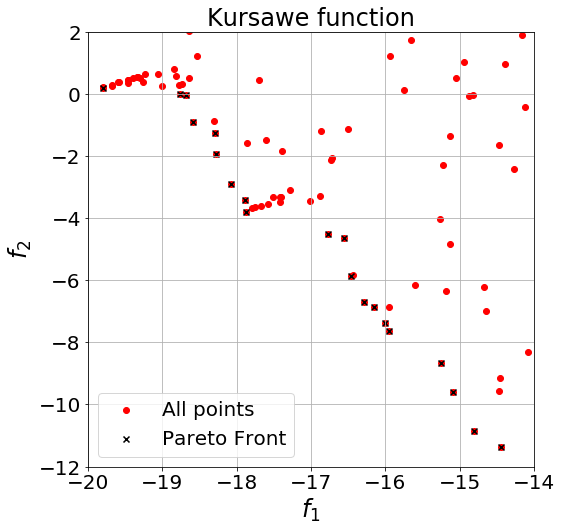

In [11]:
import matplotlib.pyplot as plt

Pareto = ParetoFront(Y_step)

fig = plt.figure(figsize=(8,8))
plt.scatter(Y_step[:,0],Y_step[:,1],c='r',label='All points')
plt.scatter(Pareto[:,0],Pareto[:,1],c='k',marker='x',label='Pareto Front')
plt.legend(loc='lower left',fontsize=20)
plt.xlim((-20.0,-14.0))
plt.ylim((-12.0,  2.0))

plt.grid()

plt.title("Kursawe function",fontsize=24)
plt.xlabel(r'$f_1$',fontsize=24)
plt.ylabel(r'$f_2$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("Kursawe.png",bbox_inches='tight')
plt.show()

In [14]:
np.savez('Kursawe.npz',X_step=X_step,Y_step=Y_step)